# Imports 


In [8]:
### MODIFY THIS LINE TO CHANGE THE RESULTS FILE
results_file = 'archive_parameter_space_results.csv'

# Only one of these should be true (or both false)
normalize_data_by_percentile = False
normalize_data_by_range = True

In [9]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn as skl
import random
from scipy.stats import powerlaw
from sklearn.linear_model import LinearRegression
import statistics
from numpy.random import normal
from scipy.spatial import distance
from tqdm import tqdm, trange
random.seed(2024)
import powerlaw
import warnings
from statistics import median
warnings.filterwarnings("ignore")
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import os
import sys

# Copy pasted fileread from other file
df_ref = pd.read_csv('VariationOf_0320_2025.csv')
df_ref = df_ref.dropna()
df_ref.reset_index(inplace=True)

g_range = sorted(df_ref['g'].unique())
lambda_range = sorted(df_ref['lam'].unique())
delta_range = sorted(df_ref['delta'].unique())

# Calculate maximum possible distance in parameter space
g_max, g_min = max(g_range), min(g_range)
lambda_max, lambda_min = max(lambda_range), min(lambda_range)
delta_max, delta_min = max(delta_range), min(delta_range)

max_distance = np.sqrt((g_max - g_min)**2 + 
                      (lambda_max - lambda_min)**2 + 
                      (delta_max - delta_min)**2)

# NaN Values

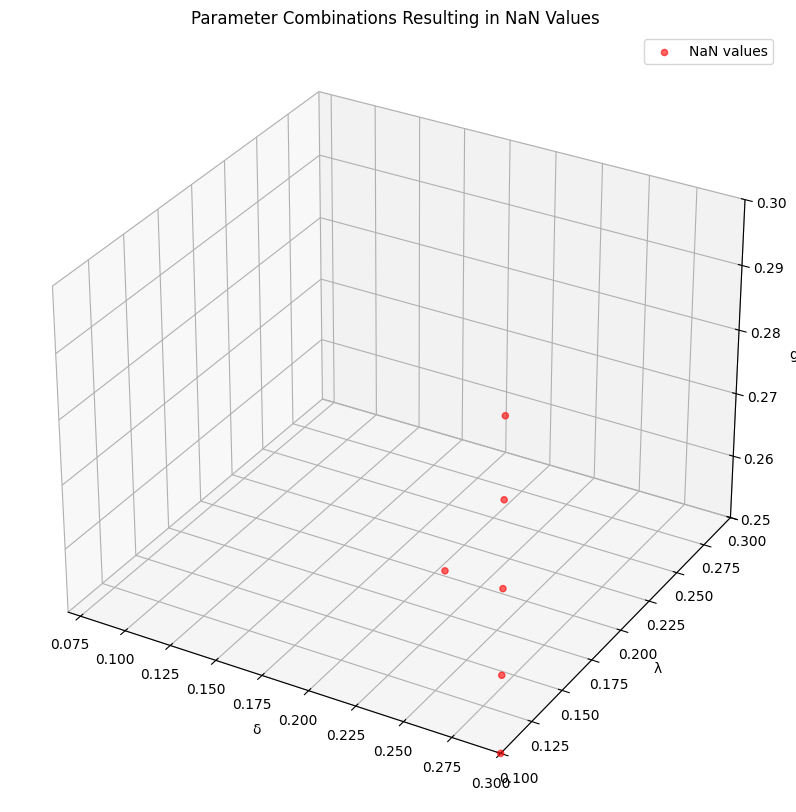

Total number of parameter combinations: 405
Number of NaN values (distance=1): 6
Percentage of NaN values: 1.48%

Parameter ranges where NaN values occur:
G range: 0.250 to 0.300
λ range: 0.100 to 0.100
δ range: 0.271 to 0.300


In [10]:
results_df = pd.read_csv(results_file)

# Plotting NaN values (where distance=1) in parameter space

# Filter for rows where distance=1
nan_df = results_df[results_df['distance'] == 1.0]

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot for NaN values
scatter = ax.scatter(nan_df['gt_delta'], 
                    nan_df['gt_lambda'], 
                    nan_df['gt_g'], 
                    c='red',  # Use red to highlight NaN values
                    alpha=0.6,
                    label='NaN values')

# Set axis limits to match the original plot
ax.set_xlim(delta_min, delta_max)
ax.set_ylim(lambda_min, lambda_max)
ax.set_zlim(g_min, g_max)

# Label axes
ax.set_xlabel('δ')
ax.set_ylabel('λ')
ax.set_zlabel('g')

# Set title
plt.title('Parameter Combinations Resulting in NaN Values')

# Add legend
plt.legend()

# Show plot
plt.show()

# Print some statistics about NaN values
print(f"Total number of parameter combinations: {len(results_df)}")
print(f"Number of NaN values (distance=1): {len(nan_df)}")
print(f"Percentage of NaN values: {(len(nan_df)/len(results_df))*100:.2f}%")

# Print the parameter ranges where we see NaN values
print("\nParameter ranges where NaN values occur:")
print(f"G range: {nan_df['gt_g'].min():.3f} to {nan_df['gt_g'].max():.3f}")
print(f"λ range: {nan_df['gt_lambda'].min():.3f} to {nan_df['gt_lambda'].max():.3f}")
print(f"δ range: {nan_df['gt_delta'].min():.3f} to {nan_df['gt_delta'].max():.3f}")


# Clean NaN Out and Normalize

In [11]:
# Replace distance=1 with NaN since these represent failed fits
results_df.loc[results_df['distance'] == 1, 'distance'] = np.nan

results_df = results_df.dropna()

normalize_header = "Percentile Normalized " if normalize_data_by_percentile else "Range Normalized " if normalize_data_by_range else ""

if normalize_data_by_percentile:
    threshold = np.percentile(results_df['distance'], 95)
    normalized_distances = results_df['distance'] / threshold
    results_df['distance'] = normalized_distances


if normalize_data_by_range:
    # Fit scaler only on ground truth
    scaler = MinMaxScaler()
    scaler.fit(results_df[['gt_g', 'gt_lambda', 'gt_delta']])

    # Transform ground-truth
    results_df[['gt_g', 'gt_lambda', 'gt_delta']] = scaler.transform(results_df[['gt_g', 'gt_lambda', 'gt_delta']])

    # Transform fitted **as plain NumPy array**, no names
    results_df[['fitted_g', 'fitted_lambda', 'fitted_delta']] = scaler.transform(
        results_df[['fitted_g', 'fitted_lambda', 'fitted_delta']].to_numpy()
    )

    # Recompute Euclidean distances between ground truth and fitted parameters
    results_df['distance'] = np.sqrt(
        (results_df['gt_g'] - results_df['fitted_g'])**2 +
        (results_df['gt_lambda'] - results_df['fitted_lambda'])**2 + 
        (results_df['gt_delta'] - results_df['fitted_delta'])**2
    )

# Grid View

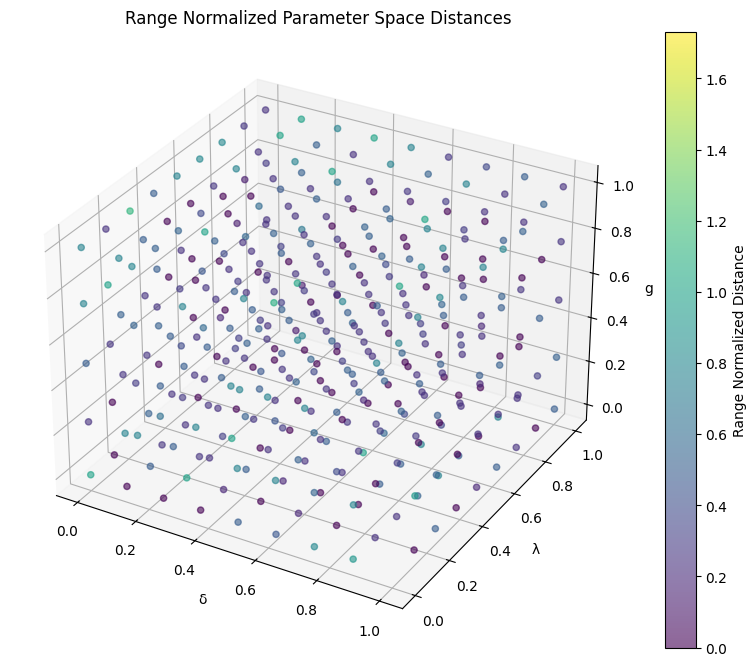

In [12]:
# Plotting for Part B of task assigned on 4/16/25

delta_values = results_df['gt_delta']
lambda_values = results_df['gt_lambda']
g_values = results_df['gt_g']
distances = results_df['distance']

# Determine max value for color scale
if normalize_data_by_range:
    vmax = np.sqrt(3)  # Max possible distance with range normalization
elif normalize_data_by_percentile:
    vmax = 1.0
else:
    vmax = max_distance

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot with color mapping to distances
scatter = ax.scatter(delta_values, lambda_values, g_values, 
                    c=distances, 
                    cmap='viridis',
                    alpha=0.6,
                    vmin=0,
                    vmax=vmax)

# Add colorbar
colorbar_label = normalize_header + 'Distance'
plt.colorbar(scatter, label=colorbar_label)

# Label axes
ax.set_xlabel('δ')
ax.set_ylabel('λ')
ax.set_zlabel('g')

# Set title
title = normalize_header + 'Parameter Space Distances'
plt.title(title)

# Show plot
plt.show()


# CDF

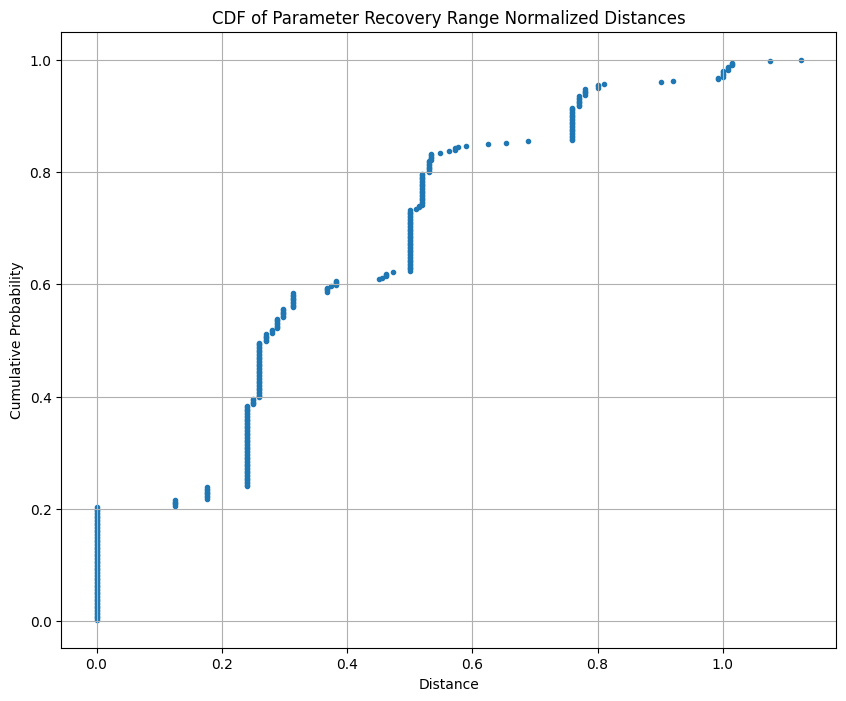

In [13]:
# Plot CDF of distances
plt.figure(figsize=(10, 8))
sorted_distances = np.sort(results_df['distance'])
cumulative_prob = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances)
plt.scatter(sorted_distances, cumulative_prob, marker='.')
plt.xlabel('Distance')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Parameter Recovery ' + normalize_header + 'Distances')
plt.grid(True)
plt.show()

# Stability


Stability Analysis
--------------------------------------------------

1. Distance-based Analysis:
Average distance: 0.3538217260489839
Median distance: 0.27060118255469634
Distance standard deviation: 0.2699296822825609

2. Parameter-specific Error Analysis:
Average errors:
g: 0.32130325814536337
lambda: 0.05357142857142857
delta: 0.03320802005012531

Median errors:
g: 0.2599999999999989
lambda: 0.0
delta: 0.0

3. Correlation Analysis:
Correlation between ground truth and fitted values:
g: 0.2696845988701812
lambda: 0.933552514749931
delta: 0.9585100467861697


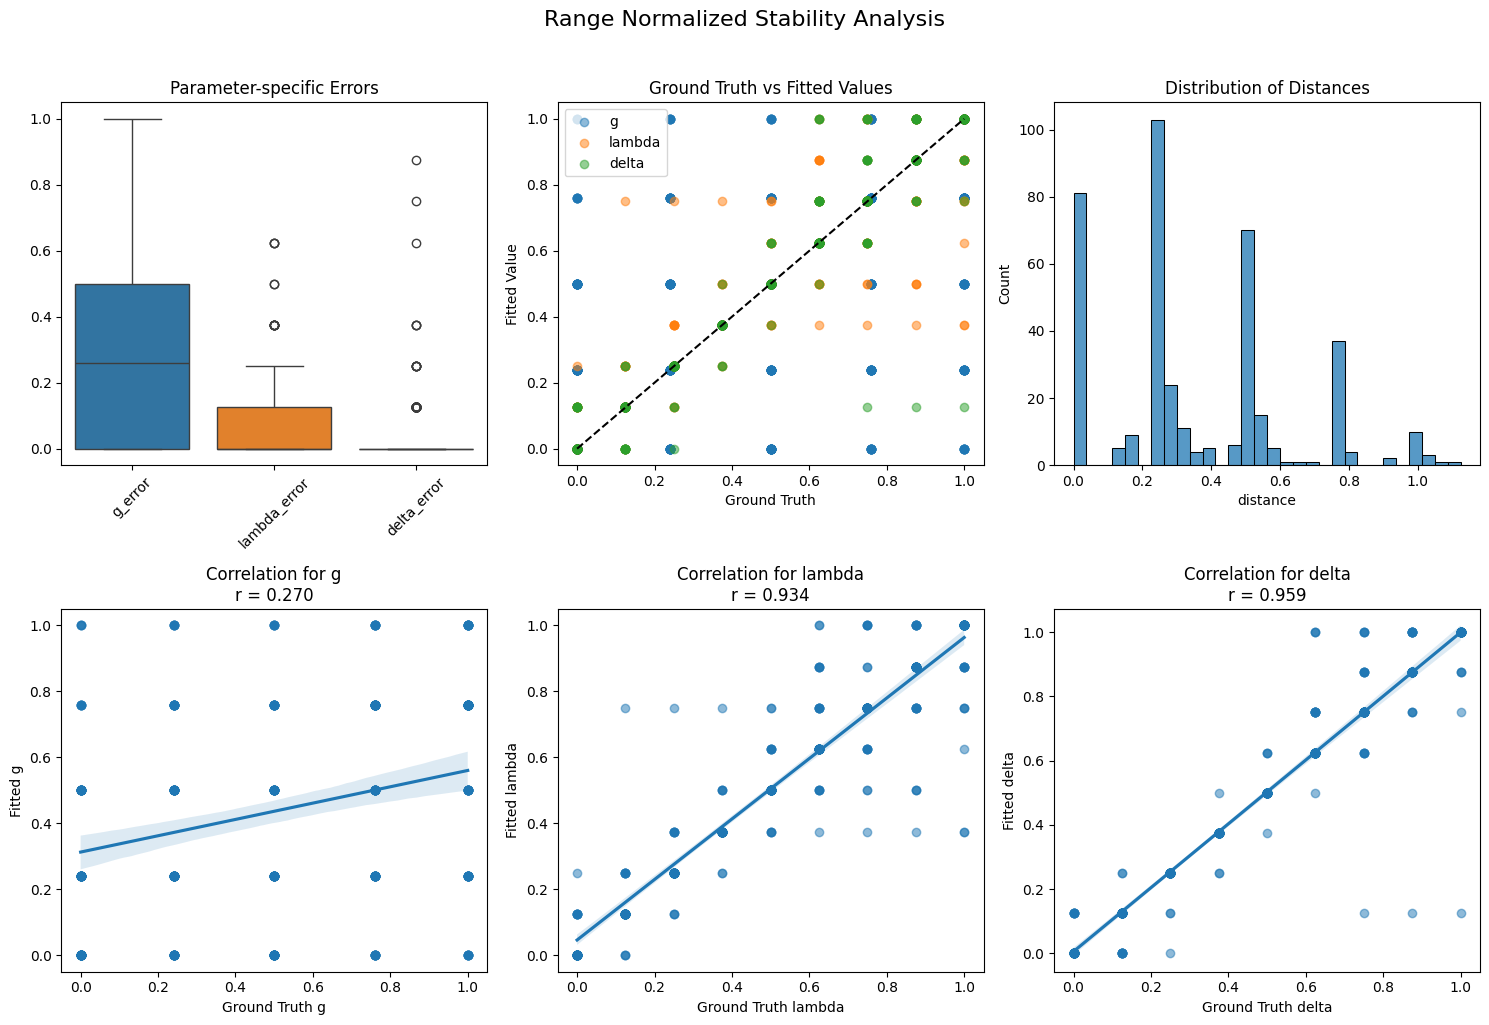

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_data(data, title):
    print(f"\n{title}")
    print("-" * 50)
    
    # 1. Distance-based Analysis
    print("\n1. Distance-based Analysis:")
    print("Average distance:", data['distance'].mean())
    print("Median distance:", data['distance'].median())
    print("Distance standard deviation:", data['distance'].std())

    # 2. Parameter-specific Error Analysis
    data['g_error'] = abs(data['gt_g'] - data['fitted_g'])
    data['lambda_error'] = abs(data['gt_lambda'] - data['fitted_lambda'])
    data['delta_error'] = abs(data['gt_delta'] - data['fitted_delta'])

    print("\n2. Parameter-specific Error Analysis:")
    print("Average errors:")
    print("g:", data['g_error'].mean())
    print("lambda:", data['lambda_error'].mean())
    print("delta:", data['delta_error'].mean())

    print("\nMedian errors:")
    print("g:", data['g_error'].median())
    print("lambda:", data['lambda_error'].median())
    print("delta:", data['delta_error'].median())

    # 3. Correlation Analysis
    print("\n3. Correlation Analysis:")
    print("Correlation between ground truth and fitted values:")
    g_corr = data['gt_g'].corr(data['fitted_g'])
    lambda_corr = data['gt_lambda'].corr(data['fitted_lambda'])
    delta_corr = data['gt_delta'].corr(data['fitted_delta'])
    print("g:", g_corr)
    print("lambda:", lambda_corr)
    print("delta:", delta_corr)
    
    return data, (g_corr, lambda_corr, delta_corr)

def create_visualizations(data, corrs):
    plt.figure(figsize=(15, 10))
    n_rows, n_cols = 2, 3

    # Plot 1: Parameter-specific errors
    plt.subplot(n_rows, n_cols, 1)
    sns.boxplot(data=data[['g_error', 'lambda_error', 'delta_error']])
    plt.title('Parameter-specific Errors')
    plt.xticks(rotation=45)

    # Plot 2: Scatter plots for each parameter
    plt.subplot(n_rows, n_cols, 2)
    plt.scatter(data['gt_g'], data['fitted_g'], alpha=0.5, label='g')
    plt.scatter(data['gt_lambda'], data['fitted_lambda'], alpha=0.5, label='lambda')
    plt.scatter(data['gt_delta'], data['fitted_delta'], alpha=0.5, label='delta')
    plt.plot([0, 1], [0, 1], 'k--')  # Perfect recovery line
    plt.title('Ground Truth vs Fitted Values')
    plt.xlabel('Ground Truth')
    plt.ylabel('Fitted Value')
    plt.legend()

    # Plot 3: Distance distribution
    plt.subplot(n_rows, n_cols, 3)
    sns.histplot(data['distance'], bins=30)
    plt.title('Distribution of Distances')

    # Plot 4: Correlation plot for g
    plt.subplot(n_rows, n_cols, 4)
    sns.regplot(data=data, x='gt_g', y='fitted_g', scatter_kws={'alpha':0.5})
    plt.title(f'Correlation for g\nr = {corrs[0]:.3f}')
    plt.xlabel('Ground Truth g')
    plt.ylabel('Fitted g')

    # Plot 5: Correlation plot for lambda
    plt.subplot(n_rows, n_cols, 5)
    sns.regplot(data=data, x='gt_lambda', y='fitted_lambda', scatter_kws={'alpha':0.5})
    plt.title(f'Correlation for lambda\nr = {corrs[1]:.3f}')
    plt.xlabel('Ground Truth lambda')
    plt.ylabel('Fitted lambda')

    # Plot 6: Correlation plot for delta
    plt.subplot(n_rows, n_cols, 6)
    sns.regplot(data=data, x='gt_delta', y='fitted_delta', scatter_kws={'alpha':0.5})
    plt.title(f'Correlation for delta\nr = {corrs[2]:.3f}')
    plt.xlabel('Ground Truth delta')
    plt.ylabel('Fitted delta')

    plt.suptitle(normalize_header + 'Stability Analysis', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    plt.close()

# Analyze data
analyzed_data, corrs = analyze_data(results_df, "Stability Analysis")

# Create visualizations
create_visualizations(analyzed_data, corrs)